In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from atpy import bellhop
import matplotlib.pyplot as plt
from matplotlib import gridspec
import concurrent.futures
import os

In [2]:
filesDir = '/Users/edwardlrichards/cir_processing/bellhopFiles/envA'
# runName = 'ctdCast_J176_1922_A'

In [3]:
#List files in directory
files = os.listdir(filesDir)
runNames = []
for file in files:
    fileName, fileExtension = os.path.splitext(file)
    if fileExtension in {'.env', '.ray', '.arr', '.prt'}:
        runNames.append(fileName)
runNames = set(runNames)
runNames

{'ctdCast_J175_1948_A',
 'ctdCast_J175_2333_A',
 'ctdCast_J176_1922_A',
 'ctdCast_J179_1654_A',
 'ctdCast_J184_2045_A',
 'ctdCast_J184_2137_A',
 'ctdCast_J185_0230_A',
 'ctdCast_J185_0305_A',
 'ctdCast_J187_0527_A',
 'ctdCast_J187_0630_A',
 'ctdCast_J187_0723_A',
 'ctdCast_J192_0642_A'}

In [4]:
def plotArrivals(runName, profile, arrivals):
    yBound_1 = (0, 100)
    xBound_1 = (1525, 1540)
    yBound_2 = (-60, -120)
    xBound_2 = (1.95, 1.97)
    
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(100,100,bottom=0.18,left=0.18,right=0.88) 

    ax1 = plt.subplot(gs[:,:20])
    _ = ax1.plot(profile['c'], profile.index)
    _ = ax1.set_xlim(xBound_1[0], xBound_1[1])
    _ = ax1.set_ylim(yBound_1[1], yBound_1[0])
    ax1.set_xticks(np.r_[xBound_1[0]:xBound_1[1]:3j])
    ax1.set_yticks(np.r_[yBound_1[1]:yBound_1[0]:4j])

    ax1.set_xlabel('Sound speed, m/s', fontsize=16)
    ax1.set_ylabel('depth, m', fontsize=16)
    
    # Plot the source and receiver depth on the sound speed profile
    plt.plot(np.mean((xBound_1[0], xBound_1[1])),\
             arrivals['sourceDepths'], 'r*')
    plt.plot(np.mean((xBound_1[0], xBound_1[1])),\
         arrivals['receiveDepth'], 'go')
    
    # ax1.set_title('Sound speed profile', fontsize=16)

    ax2 = plt.subplot(gs[:,30:100])
    for i, row in arrivals['arrivals'].iterrows():
        plotBeamArrival(row, ax2)
    _ = ax2.set_xlim(xBound_2[0], xBound_2[1])
    _ = ax2.set_ylim(yBound_2[1], yBound_2[0])
    
    plt.title(runName)

In [5]:
def plotBeamArrival(arrival_df_row, ax):
    """Plot a single point on an arrival plot """
    numTB = arrival_df_row['numTopBounce']
    numBB = arrival_df_row['numBotBounce']
    arr_db =  20 * np.log10(np.abs(arrival_df_row['amp']))

    if (numTB  == 0) and (numBB == 0):
        _ = ax.plot(arrival_df_row['delay'], arr_db, 'r.')
    elif (numTB  == 0) and (numBB <= 2):
        alpha = 0.8 ** numBB
        _ = ax.plot(arrival_df_row['delay'], arr_db, 'b.', alpha = alpha)
    elif (numTB  <= 2) and (numBB <= 2):
        alpha = 0.8 ** (numBB + numTB)
        _ = ax.plot(arrival_df_row['delay'], arr_db, 'k.', alpha = alpha)

In [6]:
def plotArrivalSpark(runName, profile, arrivals):
    dynamicRange = 40
    yBound_1 = (0, 100)
    xBound_1 = (1525, 1540)
    yBound_2 = (-(dynamicRange/1.8), (dynamicRange/1.8))
    xBound_2 = (1.95, 1.97)
    
    arr_db =  20 * np.log10(np.abs(arrivals['arrivals']['amp']))
    arr_db -= np.max(arr_db)
    arr_db += dynamicRange
    
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(100,100,bottom=0.18,left=0.18,right=0.88) 

    ax1 = plt.subplot(gs[:,:20])
    _ = ax1.plot(profile['c'], profile.index)
    _ = ax1.set_xlim(xBound_1[0], xBound_1[1])
    _ = ax1.set_ylim(yBound_1[1], yBound_1[0])
    ax1.set_xticks(np.r_[xBound_1[0]:xBound_1[1]:3j])
    ax1.set_yticks(np.r_[yBound_1[1]:yBound_1[0]:4j])

    ax1.set_xlabel('Sound speed, m/s', fontsize=16)
    ax1.set_ylabel('depth, m', fontsize=16)
    
    # Plot the source and receiver depth on the sound speed profile
    plt.plot(np.mean((xBound_1[0], xBound_1[1])),\
             arrivals['sourceDepths'], 'r*')
    plt.plot(np.mean((xBound_1[0], xBound_1[1])),\
         arrivals['receiveDepth'], 'go')
    
    # ax1.set_title('Sound speed profile', fontsize=16)

    ax2 = plt.subplot(gs[:,30:100])
    for i, row in arrivals['arrivals'].iterrows():
        plotBeamSpark(row, arr_db[i], ax2)
        
    _ = ax2.set_xlim(xBound_2[0], xBound_2[1])
    _ = ax2.set_ylim(yBound_2[1], yBound_2[0])
    
    plt.title(runName)

In [7]:
def plotBeamSpark(arrival_df_row, normArrival, ax, offset=0):
    """Plot a single point on an arrival plot """
    numTB = arrival_df_row['numTopBounce']
    numBB = arrival_df_row['numBotBounce']
    
    if normArrival > 0:
        lineWidth = normArrival / 2
        plotY = np.array([lineWidth, -lineWidth]) + offset
    else:
        return

    if (numTB  == 0) and (numBB == 0):
        _ = ax.plot([arrival_df_row['delay'],arrival_df_row['delay']],\
                    plotY, 'r')
    elif (numTB  == 0) and (numBB <= 2):
        alpha = 0.8 ** numBB
        _ = ax.plot([arrival_df_row['delay'],arrival_df_row['delay']],\
                    plotY, 'b', alpha = alpha)
    elif (numTB  <= 2) and (numBB <= 2):
        alpha = 0.8 ** (numBB + numTB)
        _ = ax.plot([arrival_df_row['delay'], arrival_df_row['delay']],\
                    plotY, 'k', alpha = alpha)

In [14]:
def plotMultiChannelSpark(runName, profile, arrivals):
    dynamicRange = 40
    rangeScale = 1/10
    yBound_1 = (0, 100)
    xBound_1 = (1525, 1540)
    yBound_2 = (35, 100)
    xBound_2 = (1.95, 1.97)
    
        
    fig = plt.figure(figsize=(8, 4)) 
    gs = gridspec.GridSpec(100,100,bottom=0.18,left=0.18,right=0.88) 

    ax1 = plt.subplot(gs[:,:20])
    _ = ax1.plot(profile['c'], profile.index)
    _ = ax1.set_xlim(xBound_1[0], xBound_1[1])
    _ = ax1.set_ylim(yBound_1[1], yBound_1[0])
    ax1.set_xticks(np.r_[xBound_1[0]:xBound_1[1]:3j])
    ax1.set_yticks(np.r_[yBound_1[1]:yBound_1[0]:4j])

    ax1.set_xlabel('Sound speed, m/s', fontsize=16)
    ax1.set_ylabel('depth, m', fontsize=16)
    
    ax2 = plt.subplot(gs[:,30:100])

    for arrival in arrivals:
        arr_db =  20 * np.log10(np.abs(arrival['arrivals']['amp']))
        arr_db -= np.max(arr_db)
        arr_db += dynamicRange
        arr_db *= rangeScale

        ax1.plot(np.mean((xBound_1[0], xBound_1[1])),\
             arrival['receiveDepth'], 'go')
        # Plot the source and receiver depth on the sound speed profile
        ax1.plot(np.mean((xBound_1[0], xBound_1[1])),\
                 arrival['sourceDepths'], 'r*')
        for i, row in arrival['arrivals'].iterrows():
            plotBeamSpark(row, arr_db[i], ax2,\
                offset=arrival['receiveDepth'])
        
    _ = ax2.set_xlim(xBound_2[0], xBound_2[1])
    _ = ax2.set_ylim(yBound_2[1], yBound_2[0])
    _ = ax2.set_xlabel('delay time, s', fontsize=16)
    
    plt.title(runName)

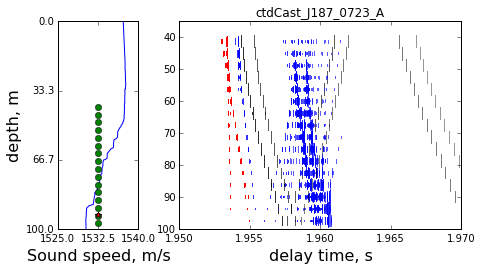

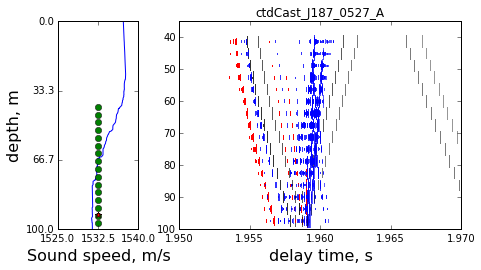

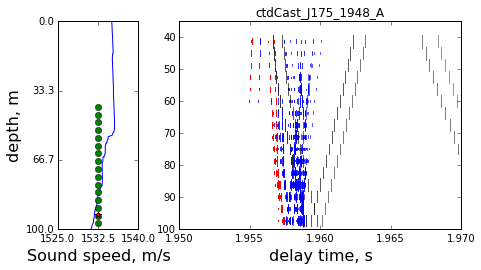

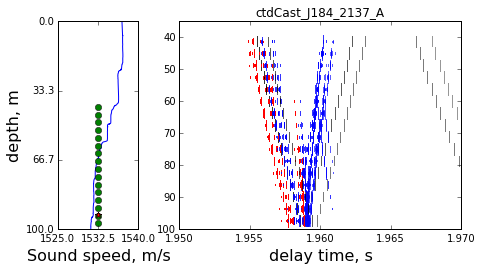

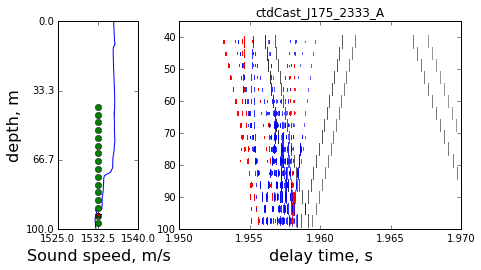

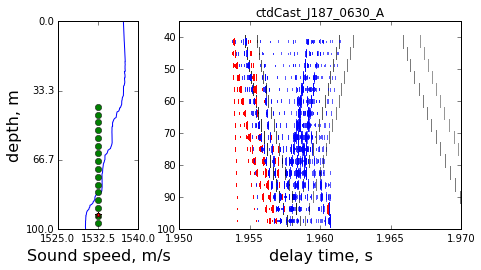

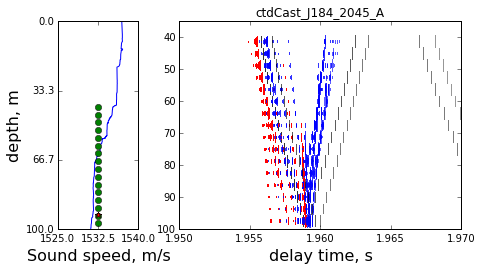

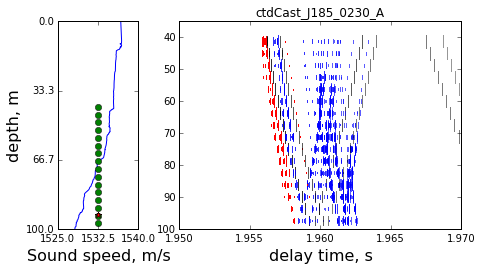

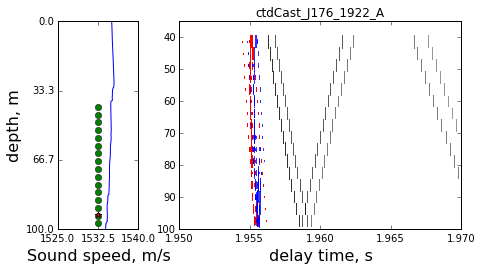

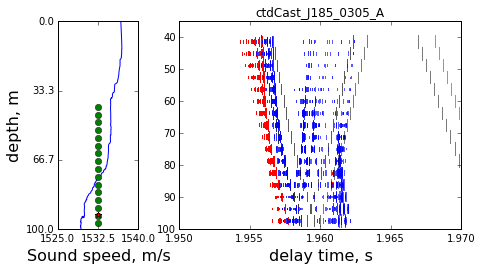

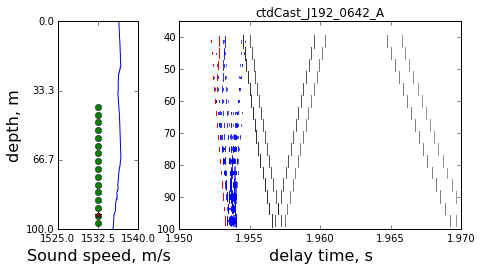

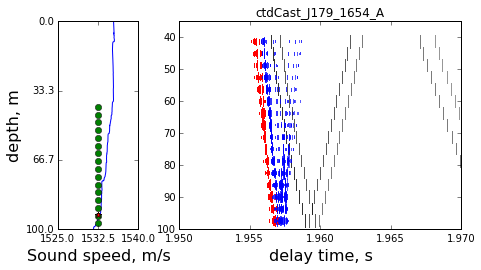

In [15]:
figDir = os.path.join(filesDir, 'figs')
for run in runNames:
    profile = bellhop.readEnv(os.path.join(filesDir, run))
    arrivals = bellhop.readArr(os.path.join(filesDir, run))
#     plotArrivals(run, profile, arrivals[0])
    plotMultiChannelSpark(run, profile, arrivals)
#     plt.savefig(os.path.join(figDir, run))